<a href="https://colab.research.google.com/github/Faisal-Al-Mamun/Birds-Species-Classification-Transfer-Learning/blob/main/Birds_Species_Classification_%7C_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* TensorFlow, Keras
* Transfer Learning
* InceptionV3

# Importing Libraries

In [ ]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.6.2
Found GPU at: /device:GPU:0


2022-02-21 14:10:51.382614: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 14:10:51.434933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:10:51.535536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:10:51.536228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout 

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sn

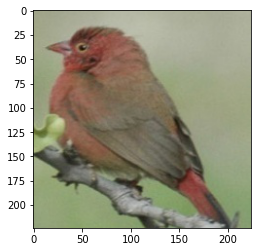

In [ ]:
# look at an image for fun

plt.imshow(image.load_img('../input/100-bird-species/train/AFRICAN FIREFINCH/003.jpg'))
plt.show()

In [ ]:
batch_size = 128
IMAGE_SIZE =  [224, 224]
train_path='../input/100-bird-species/train'
test_path='../input/100-bird-species/test'

In [ ]:
# useful for getting number of files
train_image_files = glob(train_path + '/*/*.jpg')
test_image_files = glob(test_path + '/*/*.jpg')

print(len(train_image_files))
print(len(test_image_files))

58388
2000


In [ ]:
# useful for getting number of classes
folders = glob(train_path + '/*')
print(len(folders))

400


# Inception_v3

* **Data Loading**

In [ ]:
# create an instance of ImageDataGenerator
#gen = ImageDataGenerator(rescale=1./255)
gen = ImageDataGenerator( preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

In [ ]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=128,
  class_mode='categorical'
)

test_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  batch_size=128,
  shuffle=False,
  class_mode='categorical'
)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


* **Loading Pre-Trained Model**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

inception = InceptionV3(
    input_shape=IMAGE_SIZE + [3],
    weights="imagenet",
    include_top=False)

2022-02-21 14:11:29.076148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:11:29.077163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:11:29.077817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:11:29.078703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:11:29.079371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Unfreeze the base model
inception.trainable = False

In [ ]:
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(inception.output)

x = Dense(K, activation='softmax')(x)

In [ ]:
# create a model object
inception_model = Model(inputs=inception.input, outputs=x)

In [ ]:
# view the structure of the model
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

* **Model Compailation and Model Fitting**

In [ ]:
inception_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [ ]:
# fit the model
r = inception_model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=10)

2022-02-21 14:12:28.248653: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-21 14:12:33.221183: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


457/457 [==============================] - 459s 983ms/step - loss: 109.2729 - accuracy: 0.5396 - val_loss: 38.8950 - val_accuracy: 0.7745
Epoch 2/10
457/457 [==============================] - 192s 420ms/step - loss: 34.5693 - accuracy: 0.8078 - val_loss: 40.9274 - val_accuracy: 0.8080
Epoch 3/10
457/457 [==============================] - 190s 415ms/step - loss: 24.3295 - accuracy: 0.8632 - val_loss: 37.7576 - val_accuracy: 0.8245
Epoch 4/10
457/457 [==============================] - 190s 415ms/step - loss: 19.1688 - accuracy: 0.8955 - val_loss: 44.4011 - val_accuracy: 0.8420
Epoch 5/10
457/457 [==============================] - 191s 418ms/step - loss: 15.7532 - accuracy: 0.9169 - val_loss: 36.7346 - val_accuracy: 0.8625
Epoch 6/10
457/457 [==============================] - 201s 439ms/step - loss: 14.5675 - accuracy: 0.9274 - val_loss: 38.6477 - val_accuracy: 0.8635
Epoch 7/10
457/457 [==============================] - 192s 421ms/step - loss: 13.7560 - accuracy: 0.9362 - val_loss: 35.26

* **Loss and Accuracy Graph**

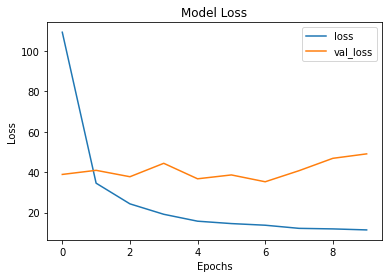

In [ ]:
# Plot what's returned by model.fit() / model.fit_generator()
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

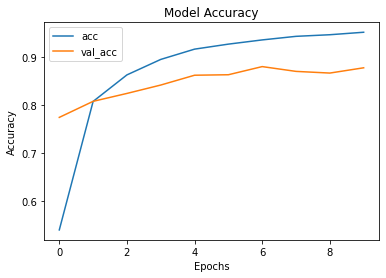

In [ ]:
##### Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()